In [184]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

Purpose of this notebook is to analyze a car efficiency dataset and apply linear regression

In [185]:
url =  "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv"

df = pd.read_csv(url)

print(df.head())

   engine_displacement  num_cylinders  horsepower  vehicle_weight  \
0                  170            3.0       159.0     3413.433759   
1                  130            5.0        97.0     3149.664934   
2                  170            NaN        78.0     3079.038997   
3                  220            4.0         NaN     2542.392402   
4                  210            1.0       140.0     3460.870990   

   acceleration  model_year  origin fuel_type         drivetrain  num_doors  \
0          17.7        2003  Europe  Gasoline    All-wheel drive        0.0   
1          17.8        2007     USA  Gasoline  Front-wheel drive        0.0   
2          15.1        2018  Europe  Gasoline  Front-wheel drive        0.0   
3          20.2        2009     USA    Diesel    All-wheel drive        2.0   
4          14.4        2009  Europe  Gasoline    All-wheel drive        2.0   

   fuel_efficiency_mpg  
0            13.231729  
1            13.688217  
2            14.246341  
3         

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

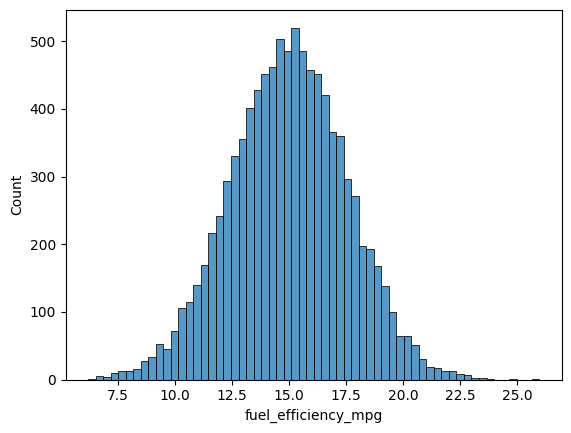

In [186]:
sns.histplot(df['fuel_efficiency_mpg'], bins=60)

In [187]:
features = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year','fuel_efficiency_mpg']
df_new = df[features]

df_new.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


In [188]:
df_new.isnull().sum()
#Horsepower has null values


engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [189]:
median_hp = df_new['horsepower'].median()
median_hp


np.float64(149.0)

In [190]:
np.random.seed(0)

n = len(df_new)

n_val = int(n *0.2)
n_test = int(n *0.2)
n_train = n - n_val - n_test

n_val, n_test, n_train

n, n_val+ n_test+ n_train

(9704, 9704)

In [191]:
idx = np.arange(n)
np.random.shuffle(idx)
idx

array([6146, 3410,  272, ..., 4859, 3264, 2732], shape=(9704,))

In [192]:
df_train = df_new.iloc[idx[:n_train]]
df_val = df_new.iloc[idx[n_train:n_train+n_val]]
df_test = df_new.iloc[idx[n_train + n_val:]]

len(df_train), len(df_val), len(df_test), len(df_train + df_val + df_test)

(5824, 1940, 1940, 9704)

In [193]:
df_train_copy = df_train.copy()
df_val_copy = df_val.copy()
df_test_copy = df_test.copy()

y_train = df_train_copy.fuel_efficiency_mpg.values
y_val = df_val_copy.fuel_efficiency_mpg.values
y_test = df_test_copy.fuel_efficiency_mpg.values



In [194]:
y_test, y_train, y_val

(array([14.55158225, 18.69533244, 18.90935401, ..., 14.54442871,
        17.23569833, 14.52465491], shape=(1940,)),
 array([17.81761862, 15.03199346, 12.34653235, ..., 17.56179153,
        19.55437001, 10.97691894], shape=(5824,)),
 array([17.03649929, 10.59334654, 12.57038257, ..., 15.47842521,
        15.82587501, 15.19168169], shape=(1940,)))

In [195]:
del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [196]:
def train_linear_regression(X, y):
    
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [197]:
def prepare_X(df):
    
    df_num = df.copy()
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

def prepare_X_mean(df):
    
    df_num = df.copy()
    mean_value = df['horsepower'].mean()
    df_num = df_num.fillna(mean_value)
    X = df_num.values
    return X

In [198]:
def rmse(y, y_pred):
    se = (y - y_pred) **2
    mse = se.mean()
    rmse = np.sqrt(mse)
    
    return rmse

In [199]:
X_train_with_0 = prepare_X(df_train)
w0, w = train_linear_regression(X_train_with_0, y_train)

X_val = prepare_X(df_val)

y_pred = w0 + X_val.dot(w)

score_with_0 = rmse(y_val, y_pred)
round(score_with_0, 2)





np.float64(0.52)

In [200]:
X_train_with_mean =  prepare_X_mean(df_train)

w0, w = train_linear_regression(X_train_with_mean, y_train)

X_val = prepare_X(df_val)

y_pred = w0 + X_val.dot(w)

score_with_mean = rmse(y_val, y_pred)
round(score_with_mean,2)

np.float64(0.61)

In [201]:
#Test make sure there no null values
X_df = pd.DataFrame(X_train_with_mean)
X_df.isna().sum()

0    0
1    0
2    0
3    0
dtype: int64

In [202]:
def train_linear_regression_regularization(X, y, r):
    
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
   
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [203]:
reg = [0.0, 0.01, 0.1, 1, 5, 10, 100]

In [204]:
for r in reg:
    X_train_with_0 = prepare_X(df_train)
    w0, w = train_linear_regression_regularization(X_train_with_0, y_train, r=r)

    X_val = prepare_X(df_val)

    y_pred = w0 + X_val.dot(w)

    reg_score_with_0 = rmse(y_val, y_pred)
    print(reg_score_with_0)


0.5206531296294218
0.5207452844954418
0.5232625264335329
0.5269999205391234
0.5276696330152039
0.5277605947940545
0.5278439857392418


In [205]:
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 42]

In [206]:
#Testing model with multiple seed values
for v in seed_values:
    np.random.seed(v)  
    idx = np.arange(n)
    np.random.shuffle(idx)

    df_train = df_new.iloc[idx[:n_train]]
    df_val = df_new.iloc[idx[n_train:n_train+n_val]]
    df_test = df_new.iloc[idx[n_train + n_val:]]

    df_train_copy = df_train.copy()
    df_val_copy = df_val.copy()
    df_test_copy = df_test.copy()

    y_train = df_train_copy.fuel_efficiency_mpg.values
    y_val = df_val_copy.fuel_efficiency_mpg.values
    y_test = df_test_copy.fuel_efficiency_mpg.values

    del df_train['fuel_efficiency_mpg']
    del df_val['fuel_efficiency_mpg']
    del df_test['fuel_efficiency_mpg']

    X_train_with_0 = prepare_X(df_train)
    w0, w = train_linear_regression(X_train_with_0, y_train)

    X_val = prepare_X(df_val)

    y_pred = w0 + X_val.dot(w)

    score_with_0 = rmse(y_val, y_pred)
    print(score_with_0)

0.5206531296294218
0.521338891285577
0.5228069974803171
0.515951674119676
0.5109129460053851
0.52834064601107
0.5313910658146311
0.5090670387381733
0.5147399129511132
0.5131865908224594
0.5173782638844466


In [207]:
std = np.std([0.5206531296294218,
0.521338891285577,
0.5228069974803171,
0.515951674119676,
0.5109129460053851,
0.52834064601107,
0.5313910658146311,
0.5090670387381733,
0.5147399129511132,
0.513186590822459, 0.5173782638844466])
std

np.float64(0.0066773912446372145)

In [208]:
np.random.seed(9)  
idx = np.arange(n)
np.random.shuffle(idx)

df_train = df_new.iloc[idx[:n_train]]
df_val = df_new.iloc[idx[n_train:n_train+n_val]]
df_test = df_new.iloc[idx[n_train + n_val:]]

df_train_copy = df_train.copy()
df_val_copy = df_val.copy()
df_test_copy = df_test.copy()

y_train = df_train_copy.fuel_efficiency_mpg.values
y_val = df_val_copy.fuel_efficiency_mpg.values
y_test = df_test_copy.fuel_efficiency_mpg.values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

df_full_train = pd.concat([df_train, df_val])
y_full_train = np.concatenate([y_train, y_val])


In [210]:
X_train_full_with_0 = prepare_X(df_full_train)
w0, w = train_linear_regression_regularization(X_train_full_with_0, y_full_train, r=0.001)

X_val = prepare_X(df_test)

y_pred = w0 + X_val.dot(w)

score_with_0 = rmse(y_test, y_pred)
round(score_with_0,3)

np.float64(0.516)